In [1]:
import pathlib
import time

import pandas as pd
import census
import us
import cpi
import datetime
# cpi.update()  # on first run

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'svg'

from tqdm.auto import tqdm

api_key = pathlib.Path('api_key_secret.txt').read_text()

c = census.Census(api_key)

In [2]:
# https://data.census.gov/cedsci/table?q=gross%20rent%20san%20francisco&g=0100000US&tid=ACSDP1Y2021.DP04

search_states = [us.states.CA.fips, us.states.MN.fips, us.states.FL.fips, us.states.MI.fips]
start_year = 2010  # Earliest year data available
end_year = datetime.date.today().year
stats_of_interest = {
    'B25064_001E': 'Median Rent',
    'B25077_001E': 'Median Value',
}

In [3]:
search_years = list(range(start_year, end_year+1))
census_data = []
reporter = tqdm(total=len(stats_of_interest)*len(search_years)*len(search_states))
for search_state in search_states:
    for stat_id, stat_name in stats_of_interest.items():
        for year in search_years:
            try:
                df = pd.DataFrame.from_records(c.acs1.get(('NAME', stat_id), {'for': 'county:*', 'in': 'state:{}'.format(search_state)}, year=year))
            except Exception:
                time.sleep(0.1)
                reporter.update()
                continue
            df = df.rename(columns={stat_id: 'Value', 'NAME': 'Name', 'state': 'State', 'county': 'County'})
            df['Statistic'] = stat_name
            df['Stat ID'] = stat_id
            df['Year'] = year
            census_data.append(df)
            time.sleep(0.1)
            reporter.update()
reporter.close()
census_data = pd.concat(census_data, ignore_index=True)
print(len(census_data))
census_data.head()

  0%|          | 0/112 [00:00<?, ?it/s]

2978


,Name,Value,State,County,Statistic,Stat ID,Year
0,"Alameda County, California",1198.0,06,001,Median Rent,B25064_001E,2010
1,"Butte County, California",862.0,06,007,Median Rent,B25064_001E,2010
2,"Contra Costa County, California",1283.0,06,013,Median Rent,B25064_001E,2010
3,"El Dorado County, California",1098.0,06,017,Median Rent,B25064_001E,2010
4,"Fresno County, California",825.0,06,019,Median Rent,B25064_001E,2010


In [4]:
census_data.drop_duplicates('State')

,Name,Value,State,County,Statistic,Stat ID,Year
0,"Alameda County, California",1198.0,06,001,Median Rent,B25064_001E,2010
970,"Anoka County, Minnesota",900.0,27,003,Median Rent,B25064_001E,2010
1306,"Alachua County, Florida",883.0,12,001,Median Rent,B25064_001E,2010
2278,"Allegan County, Michigan",675.0,26,005,Median Rent,B25064_001E,2010


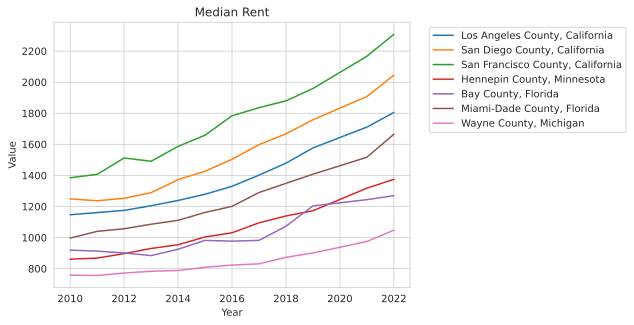

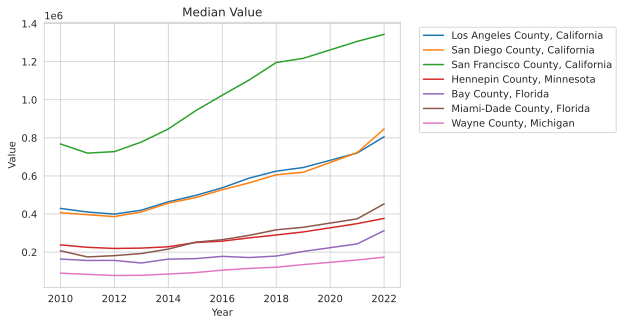

In [5]:
plot_counties = [
    'San Francisco County, California',
    # 'Alameda County, California', 'Santa Clara County, California',
    'San Diego County, California', 'Los Angeles County, California',
    # 'Riverside County, California',
    # 'Lake County, California', 'Sonoma County, California',
    'Hennepin County, Minnesota',
    'Bay County, Florida',
    'Miami-Dade County, Florida',
    'Wayne County, Michigan',
]
for stat_name in census_data['Statistic'].drop_duplicates():
    fig, ax = plt.subplots(dpi=150)
    sns.lineplot(data=census_data.loc[
        census_data['Name'].isin(plot_counties) &
        (census_data['Statistic'] == stat_name)
    ], x='Year', y='Value', hue='Name')
    ax.set_title(stat_name)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [6]:
census_wide = census_data[['Name', 'State', 'County', 'Year']].drop_duplicates()
for stat_name in census_data['Statistic'].drop_duplicates():
    census_wide = census_wide.merge(census_data.loc[census_data['Statistic'] == stat_name].drop(columns=['Statistic', 'Stat ID']).rename(columns={'Value': stat_name}), on=['Name', 'State', 'County', 'Year'], how='left')
for stat_name in census_data['Statistic'].drop_duplicates():
    census_wide[stat_name+' ({} dollars)'.format(cpi.LATEST_YEAR)] = census_wide.apply(lambda x: cpi.inflate(x[stat_name], x['Year'], to=cpi.LATEST_YEAR), axis=1)
census_wide['Price-to-Rent Ratio ({} dollars)'.format(cpi.LATEST_YEAR)] = census_wide['Median Value ({} dollars)'.format(cpi.LATEST_YEAR)] / (census_wide['Median Rent ({} dollars)'.format(cpi.LATEST_YEAR)] * 12.0)
print(len(census_wide))
census_wide.loc[census_wide['Name'] == 'San Francisco County, California'].sort_values('Year')

1489


,Name,State,County,Year,Median Rent,Median Value,Median Rent (2022 dollars),Median Value (2022 dollars),Price-to-Rent Ratio (2022 dollars)
24,"San Francisco County, California",06,075,2010,1385.0,768000.0,1858.821472,1.030740e+06,46.209386
64,"San Francisco County, California",06,075,2011,1407.0,719800.0,1830.565553,9.364898e+05,42.632078
117,"San Francisco County, California",06,075,2012,1512.0,727600.0,1927.290609,9.274449e+05,40.101411
153,"San Francisco County, California",06,075,2013,1491.0,778000.0,1873.086471,9.773717e+05,43.483121
165,"San Francisco County, California",06,075,2014,1587.0,846800.0,1961.862518,1.046821e+06,44.465448
234,"San Francisco County, California",06,075,2015,1659.0,941400.0,2048.438066,1.162387e+06,47.287523
266,"San Francisco County, California",06,075,2016,1784.0,1024000.0,2175.338719,1.248625e+06,47.832586
293,"San Francisco County, California",06,075,2017,1836.0,1104100.0,2192.047079,1.318213e+06,50.113471
328,"San Francisco County, California",06,075,2018,1880.0,1195700.0,2191.063571,1.393540e+06,53.000887
379,"San Francisco County, California",06,075,2019,1959.0,1217500.0,2242.501261,1.393693e+06,51.790880


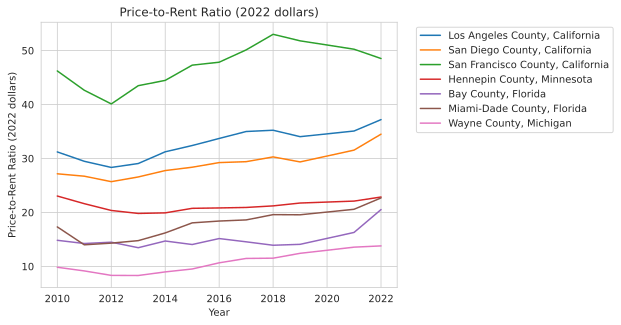

In [7]:
fig, ax = plt.subplots(dpi=150)
sns.lineplot(data=census_wide.loc[census_wide['Name'].isin(plot_counties)], x='Year', y='Price-to-Rent Ratio ({} dollars)'.format(cpi.LATEST_YEAR), hue='Name')
ax.set_title('Price-to-Rent Ratio ({} dollars)'.format(cpi.LATEST_YEAR))
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

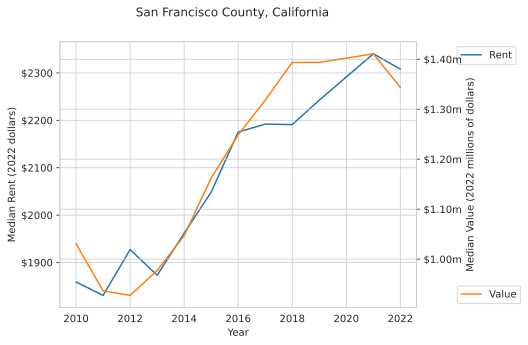

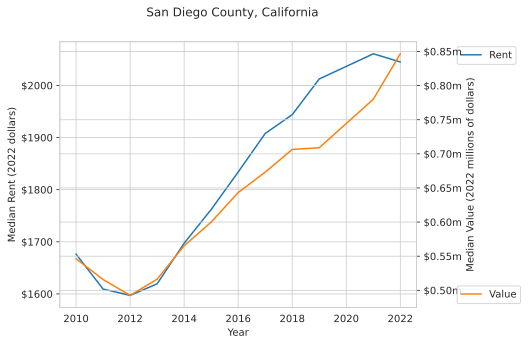

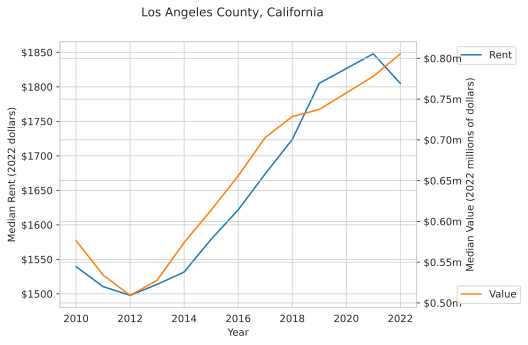

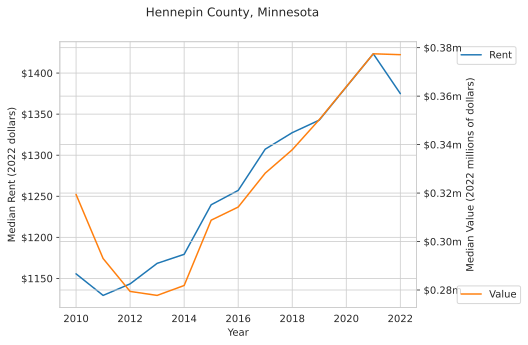

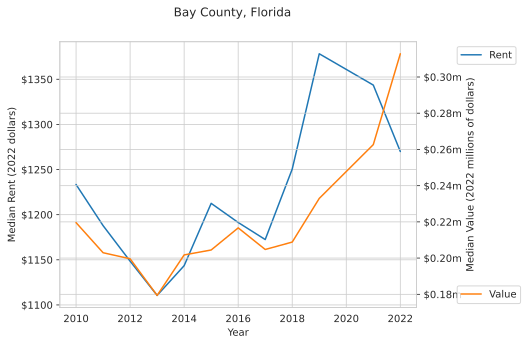

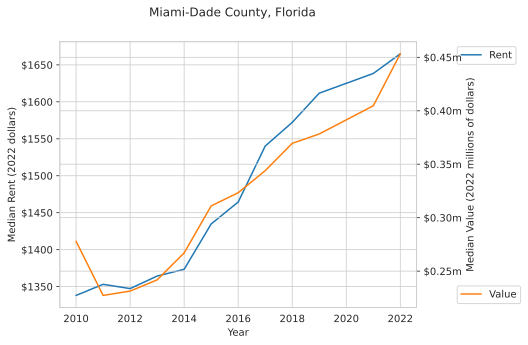

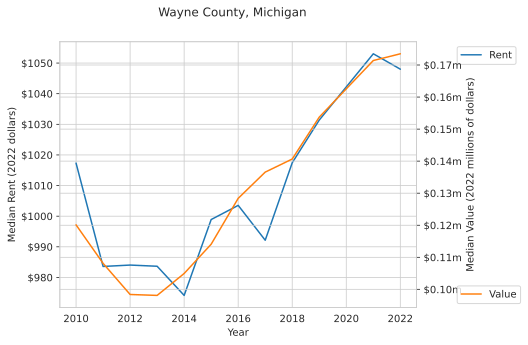

In [8]:
for plot_county in plot_counties:
    df = census_wide.loc[census_wide['Name'] == plot_county].copy()
    fig, ax1 = plt.subplots(dpi=150)
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='Year', y='Median Rent ({} dollars)'.format(cpi.LATEST_YEAR), ax=ax1, color=sns.color_palette()[0], label='Rent')
    sns.lineplot(data=df, x='Year', y='Median Value ({} dollars)'.format(cpi.LATEST_YEAR), ax=ax2, color=sns.color_palette()[1], label='Value')
    # df.head()
    ax1.legend(bbox_to_anchor=(1.1, 1), loc="upper left")
    ax2.legend(bbox_to_anchor=(1.1, 0.1), loc="upper left")
    fig.suptitle(plot_county)
    ax2.set_ylabel('Median Value ({} millions of dollars)'.format(cpi.LATEST_YEAR))
    ax1.yaxis.set_major_formatter('${x:1.0f}')
    ax2.yaxis.set_major_formatter(lambda x, y: '${:0.2f}m'.format(x/(1.0*10**6)))